plot data in genome-wide

In [175]:
# python modules
import sys
import copy
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings

In [176]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [177]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"


In [178]:
# 4-parameter logistic function (sigmoid type)
def sigmoid_func (x, top, rate, chalf, bottom):
    y = bottom + float(top-bottom)/(1+np.exp(rate*(x-chalf)))
    return y

In [179]:
# objective function to optimize parameters
def obj_func (parms, func, X, Y):
    warnings.filterwarnings("ignore")
    Y_pred = func(X, *parms)
    return np.sum((Y_pred - Y)**2)

In [180]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}


In [181]:
agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}


In [182]:
### chromosome choices
#chr_choices = cell_chrnames['H1']
chr_choices = ['chr1']
bin_size = 100000

In [183]:
### load gtab file
gtab_path = "/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/"

dinfo_dkey = {'H1_NCP_sp_1rep_10kb_score.gtab.gz':
              {'H1_NCP_sp_8_1rep' :(1, 'H1', 'score', 8)}}

chr_dkey_ID_value = load_file.read_gtab_batch (dinfo_dkey,
                                               data_path=gtab_path,
                                               chr_choices=chr_choices,
                                               by_chr_first=True)

loading H1_NCP_sp_1rep_10kb_score.gtab.gz


Done


In [184]:
### read genome size
ref_path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/ref_files/'
ref_fname = ref_path + '4D_hg38.fa'
genome_size = load_file.read_genome_size(ref_fname,
                                         chr_choices=chr_choices)

In [185]:
### read HiC eigenvector file
eigen_path = '/Users/sangwoopark/jhu_rockfish/HumanEpigeneticData/HiC/'
eigen_fname = 'eigen_H1_100kb.bedgraph'
chr_eID_eigen = load_file.read_bedgraph (eigen_path + eigen_fname,
                                         chr_choices=chr_choices,
                                         by_chr=True)

In [191]:
### average condensability over 100kb bins
dkey_binID_mvalue = {}
for chr in chr_choices:
    dkey_ID_value = chr_dkey_ID_value[chr]
    for dkey in dkey_ID_value:
        ID_value = dkey_ID_value[dkey]
        ID_loc = {ID:ID[1:] for ID in ID_value}
        binID_mvalue = statis.rbin_data_mean(bin_size,
                                             bin_size,
                                             ID_loc,
                                             ID_value,
                                             max_pos=genome_size[chr],
                                             skip_nan=True)
        
        binID_mvalue = {(chr, binID*bin_size, (binID+1)*bin_size):mvalue \
                        for binID, mvalue in binID_mvalue.items()}

        if dkey not in dkey_binID_mvalue:
            dkey_binID_mvalue[dkey] = {}
        dkey_binID_mvalue[dkey].update(binID_mvalue)

hash function is built


In [192]:
### average eigenvector over 100kb bins
binID_meigen = {}
for chr in chr_choices:
    ID_value = chr_eID_eigen[chr]
    ID_loc = {ID:ID[1:] for ID in ID_value}
    binID_mvalue = statis.rbin_data_mean(bin_size,
                                         bin_size,
                                         ID_loc,
                                         ID_value,
                                         max_pos=genome_size[chr],
                                         skip_nan=True)

    binID_meigen.update({(chr, binID*bin_size, (binID+1)*bin_size):mvalue \
                         for binID, mvalue in binID_mvalue.items()})

hash function is built


In [193]:
### reorganize HiC eigenvector data and define target IDs
dkey_targetIDs = {}
for dkey in dkey_binID_mvalue:
    binIDs = dkey_binID_mvalue[dkey].keys()
    targetIDs = set(binID_meigen.keys()) & set(binIDs)
    dkey_targetIDs[dkey] = sorted(list(targetIDs))


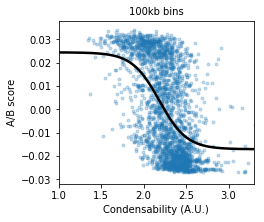

In [232]:
### scatter plot condensability vs HiC eigenvector
for dkey in dkey_binID_mvalue:
    binID_mvalue = dkey_binID_mvalue[dkey]
    X, Y = [], []
    for ID in dkey_targetIDs[dkey]:
        X.append(binID_mvalue[ID])
        Y.append(binID_meigen[ID])

    X = np.asarray(X)
    Y = np.asarray(Y)

    # sigmoid curve fitting
    p_opt, p_cov = curve_fit(sigmoid_func, X, Y)
    X_pred = np.linspace(min(X)-10, max(X)+10, 1000)
    Y_pred = sigmoid_func(X_pred, *p_opt)

    # plot figure
    fig = plt.figure(figsize=(3.5 ,3))
    plt.plot(X, Y, '.', markersize=6, alpha=0.25)
    plt.plot(X_pred, Y_pred, 'k-', linewidth=2.5)
    plt.xlim([1, 3.3])
    plt.ylim([-0.032, 0.038])
    plt.xlabel("Condensability (A.U.)", fontsize=10)
    plt.ylabel("A/B score", fontsize=10)
    plt.title("100kb bins", fontsize=10)
    plt.savefig("./data/" + "eigen_vs_score_100kb.svg",
                format="svg",
                bbox_inches='tight')
    plt.show()
    plt.close()    